In [1]:
pip install keras_applications 

Note: you may need to restart the kernel to use updated packages.


In [16]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, MaxPool2D
from keras.layers.core import Lambda
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
#from keras.utils import multi_gpu_model
from matplotlib import pyplot as plt
from keras.models import load_model
import keras.backend as K
from keras.layers.core import Lambda
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
from keras_applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
import os
from keras.layers import *

In [3]:
def Global_attention_block(inputs):
    shape=K.int_shape(inputs)
    
    x=tf.keras.layers.AveragePooling2D(pool_size=(shape[1],shape[2])) (inputs)
    x=Conv2D(shape[3],1, padding='same') (x)
    x=Activation('relu') (x)

    x=Conv2D(shape[3],1, padding='same') (x)
    x=Activation('sigmoid') (x)
    C_A=tf.keras.layers.Multiply()([x,inputs])
    
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True)) (C_A)
    x=Activation('sigmoid') (x)
    S_A=tf.keras.layers.Multiply()([x,C_A])
    return S_A

def Category_attention_block(inputs,classes,k):
    shape=K.int_shape(inputs)
    F=Conv2D(k*classes,1, padding='same') (inputs)
    F=tf.keras.layers.BatchNormalization() (F)
    F1=Activation('relu') (F)
    
    F2=F1
    x=tf.keras.layers.GlobalMaxPool2D()(F2)
    
    x=tf.keras.layers.Reshape((classes,k)) (x)
    S=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))  (x)
    
    x=tf.keras.layers.Reshape((shape[1],shape[2],classes,k)) (F1)
    x=Lambda(lambda x: K.mean(x,axis=-1,keepdims=False))  (x)
    x=tf.keras.layers.Multiply()([S,x])
    M=Lambda(lambda x: K.mean(x,axis=-1,keepdims=True))  (x)
    
    semantic=tf.keras.layers.Multiply()([inputs,M])
    return semantic

In [4]:
def smooth_curve(points, factor=0.6):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points    
   
def plotmodel(history,name):
    
    acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,smooth_curve(acc))
    #plt.plot(epochs,smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    #plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.legend(['train_acc'], loc='upper left')
    plt.savefig('acc_'+name+'.png')
    
    plt.figure(2)
    plt.plot(epochs,smooth_curve(loss))
    #plt.plot(epochs,smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.legend(['train_loss'], loc='upper right')
    plt.savefig('loss_'+name+'.png')

In [5]:
def get_base_model(model_name,image_size):
    if model_name =='vgg16':
        base_model=VGG16              (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='resnet50':
        base_model=ResNet50           (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='xception':
        base_model=Xception           (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='densenet121':    #done acc = 55% epochs:30
        base_model=DenseNet121       (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='mobilenet0.75': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=0.75,input_shape=(image_size,image_size,3))
    if model_name =='mobilenet1.0': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='mobilenetv2':
        base_model=MobileNetV2      (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='inceptionv3':   
        base_model=InceptionV3       (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='inceptionv2':
        base_model=InceptionResNetV2 (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    return base_model

In [9]:
def train_model(model,dataset,image_size,batch_size,save_name,lr1,lr2,Epochs1,Epochs2):
    #C:\Users\aokra\Dataset\Messidor\Messidor_DR__Binary_Classification\train
    dataParam={'messidor': [960,240,2,'Dataset/Messidor/Messidor_DR__Binary_Classification/train',
                            'Dataset/Messidor/Messidor_DR__Binary_Classification/test'],
               'kaggle': [30000,5126,5,'./data/kaggle/train','./data/kaggle/valid'],
               'DDR':   [9851,2503,5,'./data/DDR/train','./data/DDR/valid']} 
    
    train_num,valid_num,classes,train_dir,test_dir = dataParam[dataset]
    
    train=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=90)          
    valid = ImageDataGenerator()
    train_data=train.flow_from_directory(train_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = True,
                                         batch_size=batch_size)
    valid_data=valid.flow_from_directory(test_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = False,
                                         batch_size=batch_size)

    lr_decay=ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, verbose=1)
    #save_model=ModelCheckpoint('new/'+save_name+'{epoch:02d}.h5', monitor='val_loss',period=10)
    
    filepath = "xception_cab_messidor_weights.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='acc',verbose=1, save_best_only=True, mode='max')

    for layer in base_model.layers:
        layer.trainable = False   
        
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr1,decay=0.00001),loss=loss_fun,metrics=['acc'])
    model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs1, 
                        workers=2,
                        callbacks=[lr_decay,checkpoint])   
    
    for layer in base_model.layers:
        layer.trainable = True
        
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr2,decay=0.00001),loss=loss_fun,metrics=['acc'])
    history=model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs2,
                        workers=2,
                        callbacks=[lr_decay,checkpoint])
    
    score = model.evaluate(valid_data,batch_size = 16)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return history,model,valid_data

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "4"    
loss_fun= 'categorical_crossentropy'  
gpu_num=1
k=4
lr1=0.005
lr2=0.0001
batch_size= 16
image_size=224
classes=2

base_model=get_base_model('xception',image_size)  
base_in=base_model.input
base_out=base_model.output

x=Global_attention_block(base_out)
base_out=Category_attention_block(x,classes,k)

shape=K.int_shape(base_out)  
x=GlobalAveragePooling2D()(base_out)
out=Dense(classes,activation='softmax')(x)

parallel_model=keras.Model(base_model.input,out)
    
history,model,valid_data=train_model(parallel_model,
                                     'messidor',
                                     image_size,
                                     batch_size,
                                     'xception',
                                     lr1,lr2,1,70)

Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
60/60 [==============================] - ETA: 0s - loss: 2.3553 - acc: 0.5156
Epoch 00001: acc improved from -inf to 0.51562, saving model to xception_cab_messidor_weights.hdf5
60/60 [==============================] - 202s 3s/step - loss: 2.3553 - acc: 0.5156
Epoch 1/70
60/60 [==============================] - ETA: 0s - loss: 0.6641 - acc: 0.6135 
Epoch 00001: acc improved from 0.51562 to 0.61354, saving model to xception_cab_messidor_weights.hdf5
60/60 [==============================] - 1030s 17s/step - loss: 0.6641 - acc: 0.6135
Epoch 2/70
60/60 [==============================] - ETA: 0s - loss: 0.6250 - acc: 0.6948 
Epoch 00002: acc improved from 0.61354 to 0.69479, saving model to xception_cab_messidor_weights.hdf5
60/60 [==============================] - 1037s 17s/step - loss: 0.6250 - acc: 0.6948
Epoch 3/70
60/60 [==============================] - ETA: 0s - loss: 0.5862 - acc: 0.7292 
Epoch 00003: a

Epoch 32/70
60/60 [==============================] - ETA: 0s - loss: 0.1412 - acc: 0.9469 
Epoch 00032: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.

Epoch 00032: acc improved from 0.94583 to 0.94687, saving model to xception_cab_messidor_weights.hdf5
60/60 [==============================] - 958s 16s/step - loss: 0.1412 - acc: 0.9469
Epoch 33/70
60/60 [==============================] - ETA: 0s - loss: 0.1258 - acc: 0.9490 
Epoch 00033: acc improved from 0.94687 to 0.94896, saving model to xception_cab_messidor_weights.hdf5
60/60 [==============================] - 960s 16s/step - loss: 0.1258 - acc: 0.9490
Epoch 34/70
60/60 [==============================] - ETA: 0s - loss: 0.1205 - acc: 0.9604 
Epoch 00034: acc improved from 0.94896 to 0.96042, saving model to xception_cab_messidor_weights.hdf5
60/60 [==============================] - 962s 16s/step - loss: 0.1205 - acc: 0.9604
Epoch 35/70
60/60 [==============================] - ETA: 0s - loss: 0.1050 - acc: 0.965

60/60 [==============================] - ETA: 0s - loss: 0.0207 - acc: 0.9948 
Epoch 00064: acc did not improve from 0.99792
60/60 [==============================] - 941s 16s/step - loss: 0.0207 - acc: 0.9948
Epoch 65/70
60/60 [==============================] - ETA: 0s - loss: 0.0138 - acc: 0.9958 
Epoch 00065: acc did not improve from 0.99792
60/60 [==============================] - 941s 16s/step - loss: 0.0138 - acc: 0.9958
Epoch 66/70
60/60 [==============================] - ETA: 0s - loss: 0.0136 - acc: 0.9958 
Epoch 00066: ReduceLROnPlateau reducing learning rate to 2.09715188248083e-05.

Epoch 00066: acc did not improve from 0.99792
60/60 [==============================] - 943s 16s/step - loss: 0.0136 - acc: 0.9958
Epoch 67/70
60/60 [==============================] - ETA: 0s - loss: 0.0189 - acc: 0.9906 
Epoch 00067: acc did not improve from 0.99792
60/60 [==============================] - 938s 16s/step - loss: 0.0189 - acc: 0.9906
Epoch 68/70
60/60 [=============================

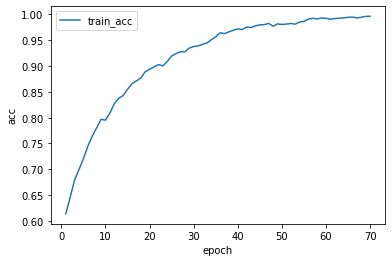

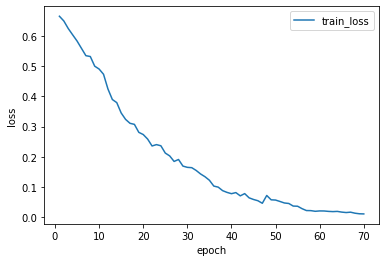

In [12]:
plotmodel(history,'xception')         

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

Y_pred = model.predict(valid_data, 240 // 4)
#print(Y_pred.shape)
#print(type(Y_pred))
print(valid_data.classes)  
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
#print(y_pred)
print('Confusion Matrix')
matrix = confusion_matrix(valid_data.classes, y_pred)

print(confusion_matrix(valid_data.classes, y_pred))
print('Classification Report')
target_names = ['non-referable', 'referable']
print(classification_report(valid_data.classes, y_pred, target_names=target_names))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[9.97606516e-01 2.39349972e-03]
 [1.09377988e-01 8.90622079e-01]
 [9.99972224e-01 2.77190902e-05]
 [9.99997377e-01 2.57727243e-06]
 [9.99997139e-01 2.88033607e-06]
 [3.17807309e-02 9.68219221e-01]
 [3.10282886e-01 6.89717054e-01]
 [9.99691486e-01 3.08576884e-04]
 [9.48043346e-01 5.19566238e-02]
 [9.99996066e-01 3.87774526e-06]
 [9.78772283e-01 2.12276876e-02]
 [9.99979138e-01 2.09032478e-05]
 [7.25623686e-04 9.99274433e-01]
 [9.99818146e-01 1.81902404e-04]
 [2.97636569e-01 7.02363431e-01]
 [5.99895045e-03 

[[ 73  24]
 [ 20 123]]
Classification Report
               precision    recall  f1-score   support

non-referable       0.78      0.75      0.77        97
    referable       0.84      0.86      0.85       143

     accuracy                           0.82       240
    macro avg       0.81      0.81      0.81       240
 weighted avg       0.82      0.82      0.82       240



In [2]:
plt.figure(figsize = (10,7))
sn.heatmap(matrix,annot=True,fmt='d')
plt.xlabel('Predicted value')
plt.ylabel('Truth')                                            

NameError: name 'plt' is not defined

In [1]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_true, y_probas, labels=['non-referable', 'referable'])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

NameError: name 'y_true' is not defined

In [40]:
from tensorflow.keras.models import Model



def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

In [44]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
  
# Save image in set directory
# Read RGB image
img = cv2.imread('Dataset/Messidor/Messidor_DR__Binary_Classification/test/non_referable/20051214_51953_0100_PP.tig') 

layer_name = 'Conv_1'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),out)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
